# Dependencies

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import csv
import math

## Plot Parameters

In [3]:
# Set font sizes globally
plt.rcParams['font.size'] = 16  # General font size
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size

# Constants

In [4]:
J = 1  # Interaction strength
k_B = 1  # Boltzmann constant (set to 1 for simplicity)
TC = 2 / np.log(1 + np.sqrt(2))  # Critical temperature

# Simulation Parameters

In [5]:
# Simulation parameters
L = 10  # Lattice size
N_sweeps_og = 50000  # Number of Monte Carlo sweeps
discard_sweeps_og = 10000  # Discard these sweeps for equilibrium
temps = [TC / 2, TC, 2 * TC]  # Temperatures

# Functions

In [6]:
def initialize_lattice(L):
    return np.random.choice([-1,1], size=(L,L))

In [7]:
def wolff_cluster_update(lattice, T):
    """Perform one Wolff cluster update with recursive cluster growth."""
    L = lattice.shape[0]
    visited = np.zeros_like(lattice, dtype=bool)  # Track visited spins
    cluster = []  # Spins in the current cluster

    # Select a random seed spin
    x, y = np.random.randint(0, L, size=2)
    seed_spin = lattice[x, y]
    cluster.append((x, y))
    visited[x, y] = True

    # Probability to add neighbors to cluster
    p_add = 1 - np.exp(-2 * J / (k_B * T))

    # Grow the cluster recursively
    while cluster:
        cx, cy = cluster.pop()  # Current spin in the cluster
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Neighboring directions
            nx, ny = (cx + dx) % L, (cy + dy) % L  # Periodic boundary conditions
            if not visited[nx, ny] and lattice[nx, ny] == seed_spin:
                if np.random.rand() < p_add:
                    cluster.append((nx, ny))
                    visited[nx, ny] = True

    # Flip the entire cluster
    lattice[visited] *= -1

    return lattice

In [8]:
def magnetization_density(lattice):
    return np.sum(lattice) / lattice.size


In [9]:
# Further analysis: Autocorrelation, binning, squared magnetization, and susceptibility
def binning_analysis(data, max_bin_size):
    """Perform binning analysis for statistical error estimation."""
    bin_sizes = np.logspace(1, np.log10(max_bin_size), num=20, base=10, dtype=int)
    errors = []

    for bin_size in bin_sizes:
        binned_data = np.mean(data[:len(data) - len(data) % bin_size].reshape(-1, bin_size), axis=1)
        error = np.std(binned_data) / np.sqrt(len(binned_data))
        errors.append(error)

    return bin_sizes, errors

In [10]:
def theoretical_cluster_size(T):
    p_add = 1 - np.exp(-2 * J / (k_B * T))
    return (1 + p_add) / (1 - p_add)

In [11]:
# Calculating the right number of updates for the wished number of sweeps 
def updates_per_sweep(T):
    return math.ceil((L**2) / theoretical_cluster_size(T))
def N_sweep_calc(T):
    return math.ceil(N_sweeps_og * updates_per_sweep(T))
def discard_sweeps_calc(T):
    return math.ceil(discard_sweeps_og * updates_per_sweep(T))



# (a)

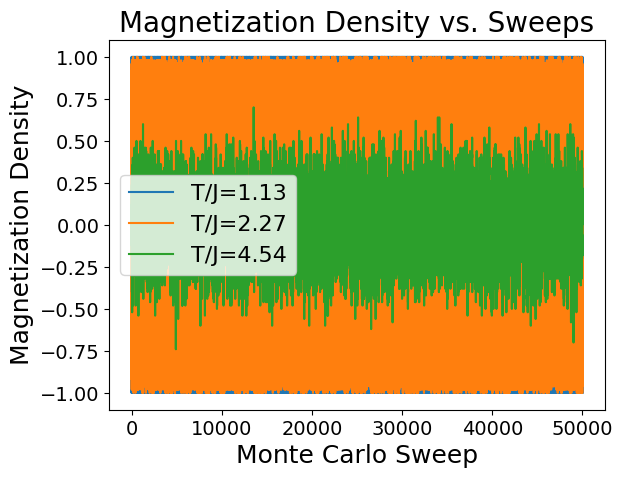

In [11]:
np.random.seed(42)
# Magnetization density evolution

results = {}
for T in temps:
    # Calculating the right number of updates for the wished number of sweeps 
    # N_sweeps = N_sweep_calc(T)
    # discard_sweeps = discard_sweeps_calc(T)

    N_sweeps = N_sweeps_og
    discard_sweeps = discard_sweeps_og

    lattice = initialize_lattice(L)
    magnetizations = []

    for sweep in range(N_sweeps):
        lattice = wolff_cluster_update(lattice, T)
        # if sweep % updates_per_sweep(T) == 0:
        magnetizations.append(magnetization_density(lattice))

    results[T] = magnetizations

    # Save results to CSV
    with open(f'Data_single/a_magnetization_T_{T:.2f}.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Sweep', 'Magnetization Density'])
        for i, m in enumerate(magnetizations):
            csvwriter.writerow([i, m])

# Plot magnetization density
for T, mags in results.items():
    plt.plot(mags, label=f"T/J={T:.2f}")

plt.xlabel("Monte Carlo Sweep")
plt.ylabel("Magnetization Density")
plt.legend()
plt.title("Magnetization Density vs. Sweeps")
plt.show()



### plots

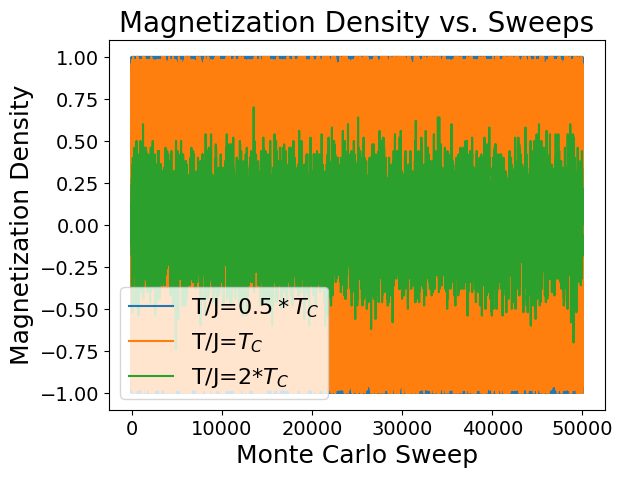

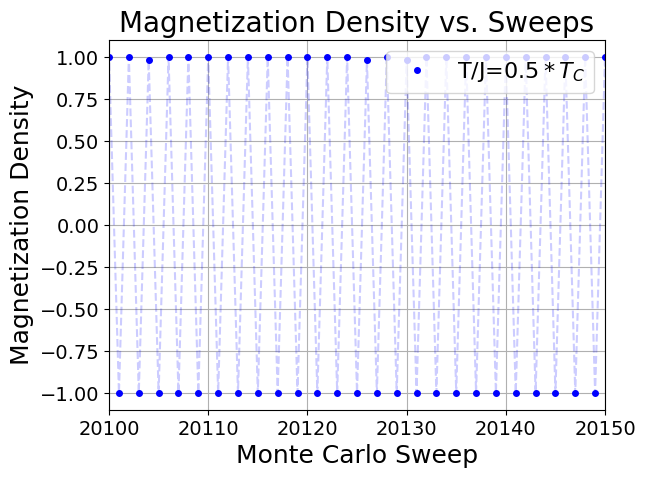

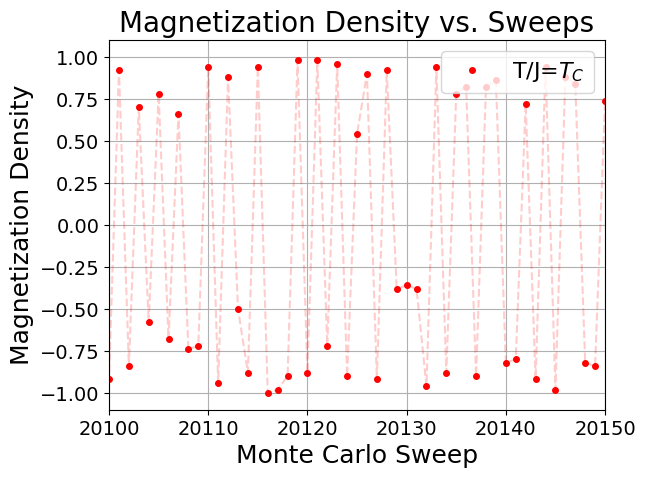

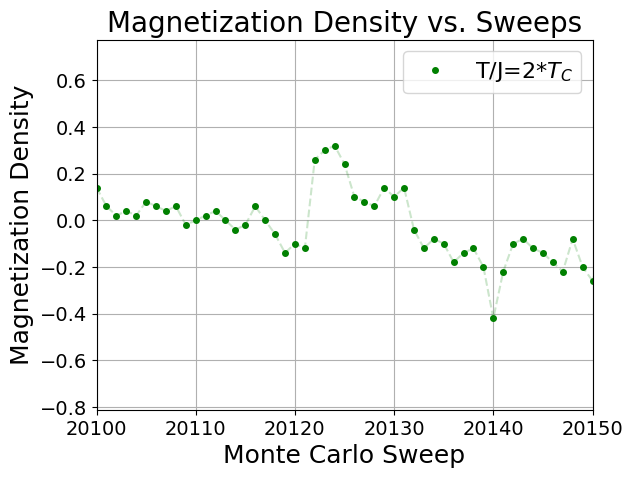

In [26]:
tc_vals = ["$0.5* T_C$", "$T_C$", "2*$T_C$"]
colors = ["blue", "red", "green"]

for T in temps:
    magnetizations = []
    with open(f'Data_single/a_magnetization_T_{T:.2f}.csv', 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header
        for row in csvreader:
            magnetizations.append(float(row[1]))

    plt.plot(magnetizations, label=f"T/J={tc_vals[temps.index(T)]}")

plt.xlabel("Monte Carlo Sweep")
plt.ylabel("Magnetization Density")
plt.legend()
plt.title("Magnetization Density vs. Sweeps")
plt.savefig("Plots01/a_magnetization.png", bbox_inches= "tight")
plt.show()



for T in temps:
    magnetizations = []
    with open(f'Data_single/a_magnetization_T_{T:.2f}.csv', 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header
        for row in csvreader:
            magnetizations.append(float(row[1]))

    plt.plot(magnetizations, color = colors[temps.index(T)], ls = 'dashed', alpha = 0.2)
    plt.plot(magnetizations, label=f"T/J={tc_vals[temps.index(T)]}", color = colors[temps.index(T)], marker = 'o', markersize = 4, ls = '', alpha = 1)
    plt.xlabel("Monte Carlo Sweep")
    plt.ylabel("Magnetization Density")
    plt.xlim(20100,20150)
    plt.legend(loc = 'upper right')
    plt.title("Magnetization Density vs. Sweeps")
    plt.grid(True)

    plt.savefig(f"Plots01/a_magnetization_zoom_{T:.2f}.png", bbox_inches= "tight")
    plt.show()


# (b)

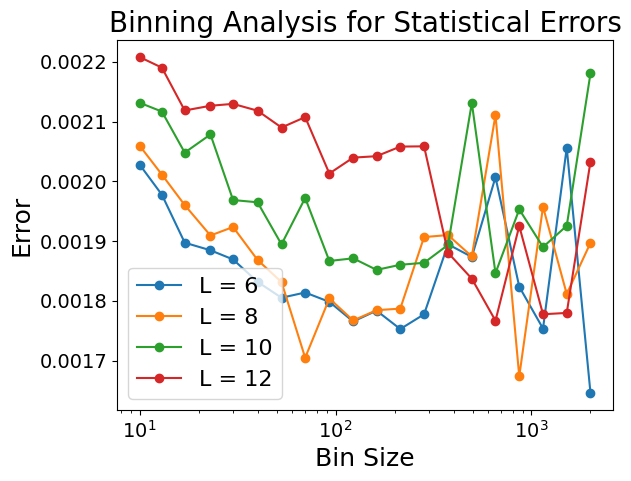

In [30]:
np.random.seed(42)

# Example binning analysis
Ls = [6,8,10,12]
# Calculating the right number of updates for the wished number of sweeps 
N_sweeps = 2*N_sweeps_og
discard_sweeps = 3*discard_sweeps_og
# N_sweeps = N_sweep_calc(TC)
# discard_sweeps = discard_sweeps_calc(TC)
for L in Ls:
    T_example = TC
    lattice = initialize_lattice(L)
    magnetizations_example = []
    for sweep in range(N_sweeps):
        lattice = wolff_cluster_update(lattice, T_example)
        if sweep >= 2*discard_sweeps:
            #if sweep % updates_per_sweep(TC) == 0: 
            magnetizations_example.append(magnetization_density(lattice))

    # Convert the list to a NumPy array
    magnetizations_example = np.array(magnetizations_example)

    # Perform binning analysis and save to CSV
    bin_sizes, errors = binning_analysis(magnetizations_example, max_bin_size=2000)
    with open(f'Data_single/b_binning_analysis_L_{L}.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Bin Size', 'Error'])
        for size, error in zip(bin_sizes, errors):
            csvwriter.writerow([size, error])

    plt.plot(bin_sizes, errors, marker="o", label = f"L = {L}")

plt.xscale("log")
plt.xlabel("Bin Size")
plt.ylabel("Error")
plt.title("Binning Analysis for Statistical Errors")
plt.legend()
plt.show()

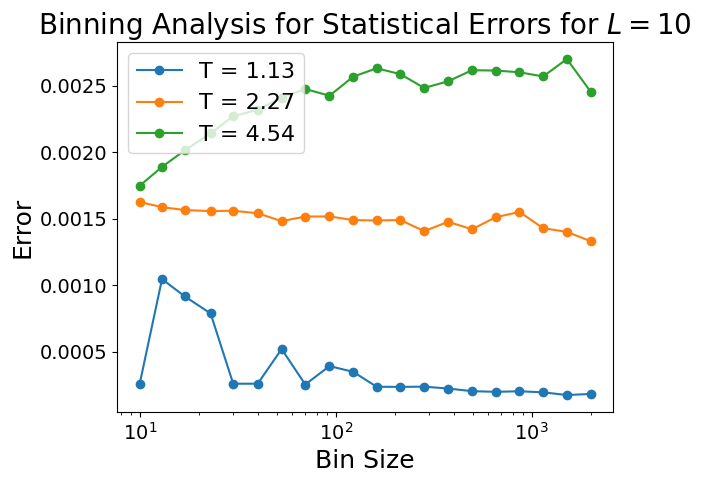

In [31]:
np.random.seed(42)

L = 10

for T in temps:
    N_sweeps = 2*N_sweeps_og
    discard_sweeps = 3*discard_sweeps_og
    # N_sweeps = N_sweep_calc(TC)
    # discard_sweeps = discard_sweeps_calc(TC)
    T_example = T
    lattice = initialize_lattice(L)
    magnetizations_example = []
    for sweep in range(N_sweeps):
        lattice = wolff_cluster_update(lattice, T_example)
        if sweep >= discard_sweeps:
            #if sweep % updates_per_sweep(TC) == 0: 
            magnetizations_example.append(magnetization_density(lattice))

    # Convert the list to a NumPy array
    magnetizations_example = np.array(magnetizations_example)

    # Perform binning analysis and save to CSV
    bin_sizes, errors = binning_analysis(magnetizations_example, max_bin_size=2000)
    with open(f'Data_single/b_binning_analysis_L_{L}_T_{T:.2f}.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Bin Size', 'Error'])
        for size, error in zip(bin_sizes, errors):
            csvwriter.writerow([size, error])

    plt.plot(bin_sizes, errors, marker="o", label = f"T = {T:.2f}")
plt.xscale("log")
plt.xlabel("Bin Size")
plt.ylabel("Error")
plt.title("Binning Analysis for Statistical Errors for $L=10$")
plt.legend()
plt.show()

### plots

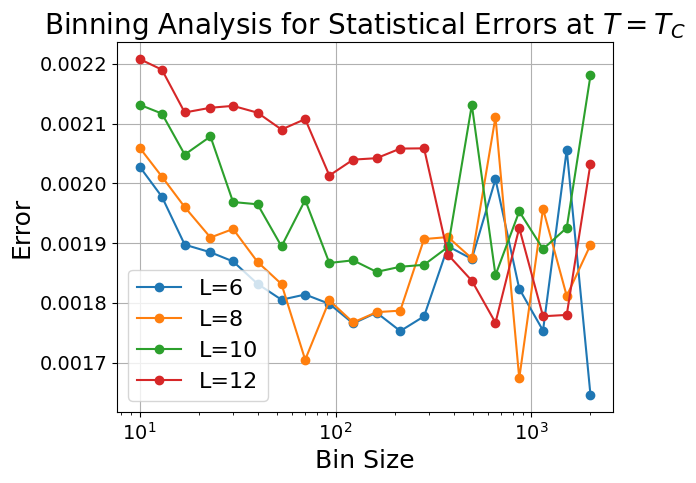

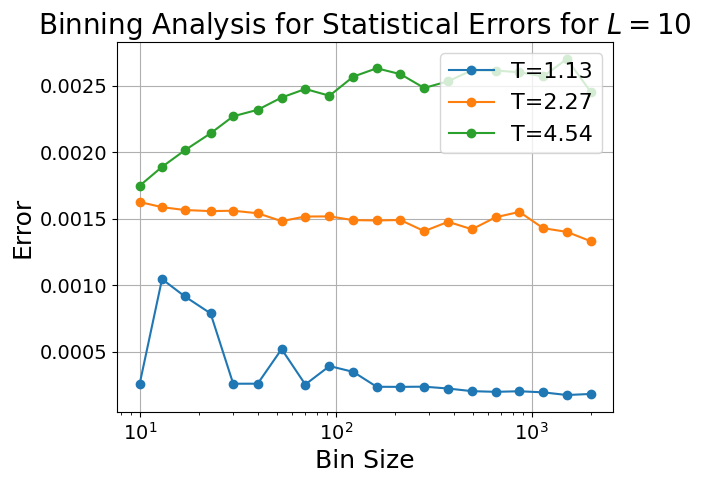

In [42]:

for L in Ls:
    bin_sizes = []
    errors = []
    with open(f'Data_single/b_binning_analysis_L_{L}.csv', 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header
        for row in csvreader:
            bin_sizes.append(float(row[0]))
            errors.append(float(row[1]))

    plt.plot(bin_sizes, errors, marker="o", label=f"L={L}")

plt.xscale("log")
plt.xlabel("Bin Size")
plt.ylabel("Error")
plt.grid(True)
plt.legend(loc = "lower left")
plt.title("Binning Analysis for Statistical Errors at $ T = T_C $")

plt.savefig("Plots01/b_binning_errors_at_TC.png", bbox_inches= "tight")
plt.show()


L = 10
for T in temps:
    bin_sizes = []
    errors = []
    with open(f'Data_single/b_binning_analysis_L_10_T_{T:.2f}.csv', 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header
        for row in csvreader:
            bin_sizes.append(float(row[0]))
            errors.append(float(row[1]))

    plt.plot(bin_sizes, errors, marker="o", label=f"T={T:.2f}")

plt.xscale("log")
plt.xlabel("Bin Size")
plt.ylabel("Error")
plt.grid(True)
plt.legend(loc = "upper right")
plt.title("Binning Analysis for Statistical Errors for $ L = 10 $")

plt.savefig("Plots01/b_binning_errors_at_L_10.png", bbox_inches= "tight")
plt.show()

# (c)

In [25]:
np.random.seed(42)
# Additional system sizes and temperature range
Ls = [6,8,10,12]
temperatures = np.linspace(0.5, 4.0, 100)  # Range of temperatures

def compute_observables(L, temperatures, N_sweeps=50000, discard_sweeps=10000):
    """Compute <m^2> and susceptibility for given lattice size and temperatures."""
    m2_results = []
    susceptibility_results = []
    errors_m2 = []
    errors_chi = []

    for T in temperatures:
        lattice = initialize_lattice(L)
        magnetizations = []
        
        N_sweeps = N_sweeps_og
        discard_sweeps = discard_sweeps_og
        # N_sweeps = N_sweep_calc(TC)
        # discard_sweeps = discard_sweeps_calc(TC)

        for sweep in range(N_sweeps):
            lattice = wolff_cluster_update(lattice, T)
            if sweep >= discard_sweeps:
                magnetizations.append(magnetization_density(lattice))

        # Convert to NumPy array
        magnetizations = np.array(magnetizations)

        # Compute squared magnetization
        m2 = np.mean(magnetizations**2)
        m = np.mean(np.abs(magnetizations))
        # Compute susceptibility
        chi = (L**2 / (k_B * T)) * (m2 - m**2)

        # Perform binning analysis for error estimation
        bin_sizes, errors_m2_binned = binning_analysis(magnetizations**2, max_bin_size=2000)
        _, errors_chi_binned = binning_analysis(
            (L**2 / (k_B * T)) * (magnetizations**2 - m**2), max_bin_size=2000
        )

        # Append results
        m2_results.append(m2)
        susceptibility_results.append(chi)
        errors_m2.append(errors_m2_binned[-1])  # Largest bin size error
        errors_chi.append(errors_chi_binned[-1])  # Largest bin size error

    return m2_results, susceptibility_results, errors_m2, errors_chi


# Save results to CSV files for each L
for L in Ls:
    m2_results, susceptibility_results, errors_m2, errors_chi = compute_observables(L, temperatures)

    # Create the CSV filename
    filename = f"Data_single/c_d_data_L_{L}_t_steps_100.csv"

    # Write the data to a CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Temperature', 'Squared_Magnetization', 'Susceptibility', 'Error_m2', 'Error_chi'])
        # Write the data rows
        for temp, m2, chi, err_m2, err_chi in zip(temperatures, m2_results, susceptibility_results, errors_m2, errors_chi):
            writer.writerow([temp, m2, chi, err_m2, err_chi])




### plots

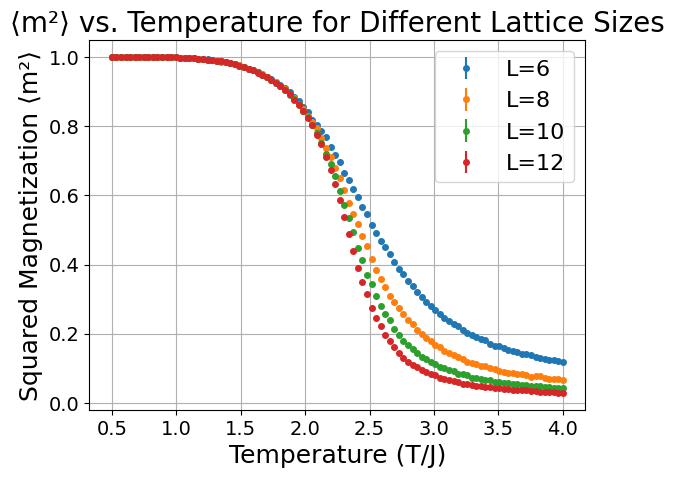

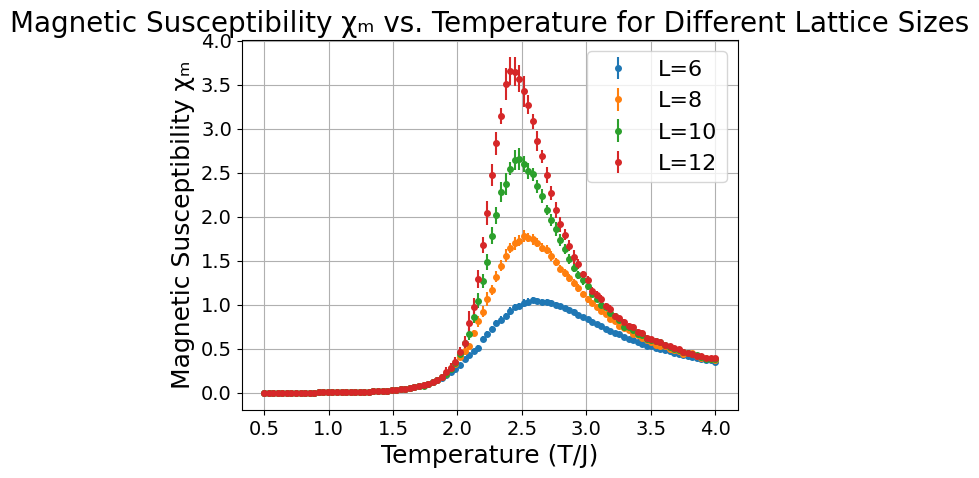

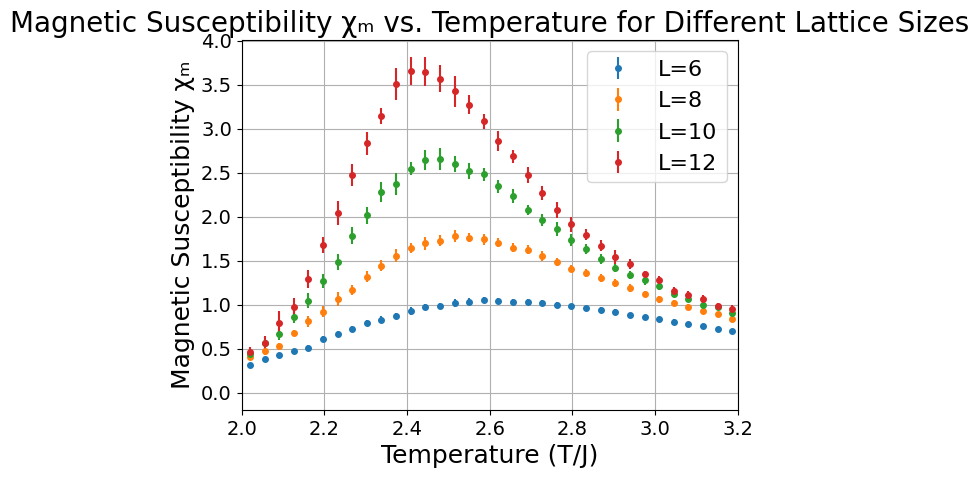

In [14]:
# Now let's read the data back and plot it
# Ls = [2,3,4,5,6,7,8,9,10,11,12,13,14]
# Ls = [2,3,4,5,7,6,8,10,12]
Ls = [6,8,10,12]
for L in Ls:
    # Load data from the CSV file
    filename = f"Data_single/c_d_data_L_{L}_t_steps_100.csv"
    temperatures = []
    m2_results = []
    susceptibility_results = []
    errors_m2 = []
    errors_chi = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Skip the header
        next(reader)
        for row in reader:
            temperatures.append(float(row[0]))
            m2_results.append(float(row[1]))
            susceptibility_results.append(float(row[2]))
            errors_m2.append(float(row[3]))
            errors_chi.append(float(row[4]))

    # Plot <m^2>
    plt.errorbar(temperatures, m2_results, yerr=errors_m2, label=f"L={L}", marker="o", ls = '', markersize = 4)

plt.xlabel("Temperature (T/J)")
plt.ylabel("Squared Magnetization ⟨m²⟩")
plt.legend()
plt.title("⟨m²⟩ vs. Temperature for Different Lattice Sizes")
plt.grid(True)

plt.savefig("Plots01/c_m2_over_T.png", bbox_inches= "tight")
plt.show()

# Plot susceptibility
for L in Ls:
    # Load data from the CSV file
    filename = f"Data_single/c_d_data_L_{L}_t_steps_100.csv"
    temperatures = []
    m2_results = []
    susceptibility_results = []
    errors_m2 = []
    errors_chi = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Skip the header
        next(reader)
        for row in reader:
            temperatures.append(float(row[0]))
            m2_results.append(float(row[1]))
            susceptibility_results.append(float(row[2]))
            errors_m2.append(float(row[3]))
            errors_chi.append(float(row[4]))
    # Plot susceptibility
    plt.errorbar(temperatures, susceptibility_results, yerr=errors_chi, label=f"L={L}", marker="o", ls = '', markersize = 4)

plt.xlabel("Temperature (T/J)")
plt.ylabel("Magnetic Susceptibility χₘ")
plt.legend()
plt.title("Magnetic Susceptibility χₘ vs. Temperature for Different Lattice Sizes")
plt.grid(True)

plt.savefig("Plots01/d_magnetic.png", bbox_inches= "tight")
plt.show()

# Plot susceptibility
for L in Ls:
    # Load data from the CSV file
    filename = f"Data_single/c_d_data_L_{L}_t_steps_100.csv"
    temperatures = []
    m2_results = []
    susceptibility_results = []
    errors_m2 = []
    errors_chi = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Skip the header
        next(reader)
        for row in reader:
            temperatures.append(float(row[0]))
            m2_results.append(float(row[1]))
            susceptibility_results.append(float(row[2]))
            errors_m2.append(float(row[3]))
            errors_chi.append(float(row[4]))
    # Plot susceptibility
    plt.errorbar(temperatures, susceptibility_results, yerr=errors_chi, label=f"L={L}", marker="o", ls = '', markersize = 4)

plt.xlabel("Temperature (T/J)")
plt.ylabel("Magnetic Susceptibility χₘ")
plt.legend()
plt.xlim(2,3.2)
plt.title("Magnetic Susceptibility χₘ vs. Temperature for Different Lattice Sizes")
plt.grid(True)

plt.savefig("Plots01/d_magnetic_zoom.png", bbox_inches= "tight")
plt.show()